In [23]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random

In [14]:
## Query Neo4j database to retrieve graph
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [15]:
# NetworkX Non directed graph definition
G = nx.Graph()

# Load nodes
nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

# Load edges
rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [16]:
## Get connected components and pick the greatest one
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G=S[0]

The total number of components is:  12219


In [20]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [34]:
# Get array with intermediaries id's which can be connected with orphan entity
def get_ids_intermediaries(G,tupla,id_intermediary):
    ids_intermediaries = []
    entities_object = G.edges(tupla[1])
    for entity_neighbors in entities_object:
        # if it's officer
        if G.nodes[entity_neighbors[1]]['kind'] == 'Officer':
            id_officer = entity_neighbors[1]
            # Iterate over neighbors (Entities)
            for entidades_vecinas_officer in G.edges(id_officer):
                # Iterate over entity relationships
                for adjacencias_entidad in G.edges(entidades_vecinas_officer[1]):
                    # If neighbor is intermediary and has not been added yet to array
                    if G.nodes[adjacencias_entidad[1]]['kind'] == 'Intermediary':
                        if id_intermediary != adjacencias_entidad[1] and adjacencias_entidad[1] not in ids_intermediaries:
                            ids_intermediaries.append(adjacencias_entidad[1])
                        break
    return ids_intermediaries

# Compute for each orphan entity, which new intermediaries can be related with them - Supervised percolation
def recompute_edges(G,id_intermediary):
    vueltas = 0
    for i in G.edges(id_intermediary):
        new_id_intermediaries = get_ids_intermediaries(G,i,id_intermediary)
        if new_id_intermediaries:
            max_degree_id = max(dict(G.degree(new_id_intermediaries)), key=dict(G.degree(new_id_intermediaries)).get)
            G.add_edge(max_degree_id, i[1], key=G[id_intermediary][i[1]], type='INTERMEDIARY_OF')
        vueltas = vueltas+1

def recompute_edges_random(G,id_intermediary):
    vueltas = 0
    for i in G.edges(id_intermediary):
        new_id_intermediaries = get_ids_intermediaries(G,i,id_intermediary)
        if new_id_intermediaries:
            node_id_percolation = random.choice(new_id_intermediaries)
            G.add_edge(node_id_percolation, i[1], key=G[id_intermediary][i[1]], type='INTERMEDIARY_OF')
        vueltas = vueltas+1
    print(vueltas)

# Percolation algorithm
# Track at each iteration GCC and SLCC proportion along with number of connected components
def percolation_algorithm(G,random_percolation=True,autodefense=False):
    random.seed(32)
    total_graph = G.number_of_nodes()
    scatter_gcc = [[0,1]] # Proportion GCC at each iteration
    scatter_slcc = [[0,0]] # Proportion SLCC at each iteration
    scatter_cc = [[0,1]] # Number of components at each iteration
    current_length_gcc = total_graph
    Percolation_graph = G.copy() # Make a graph copy
    i=1
    while current_length_gcc/total_graph > 0.05:
        node_id_to_remove = None
        if len(list(dict(Percolation_graph.degree(labels['Intermediary'])).keys())) > 0:
            if not random_percolation:
                node_id_to_remove = max(dict(Percolation_graph.degree(labels['Intermediary'])), key=dict(Percolation_graph.degree(labels['Intermediary'])).get)
            else:
                node_id_to_remove = random.choice(list(dict(Percolation_graph.degree(labels['Intermediary'])).keys()))
            if autodefense:
                recompute_edges(Percolation_graph,node_id_to_remove)
            Percolation_graph.remove_node(node_id_to_remove)
            G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
            scatter_cc.append([i,len(G_sorted)])
            Gcc = Percolation_graph.subgraph(G_sorted[0])
            Slcc = Percolation_graph.subgraph(G_sorted[1])
            current_length_gcc = len(Gcc)
            current_length_slcc = len(Slcc)
            print('The total number of components in Gcc is: ',current_length_gcc)
            print('The total number of components in Slcc is: ',current_length_slcc)
            print('Proportion gcc',current_length_gcc/total_graph)
            print('Proportion slcc',current_length_slcc/total_graph)
            scatter_gcc.append([i,current_length_gcc/total_graph])
            scatter_slcc.append([i,current_length_slcc/total_graph])
            i=i+1
        else:
            break
    return scatter_gcc,scatter_slcc,scatter_cc

In [35]:
#Supervised percolation without autodefense
scatter_gcc,scatter_slcc,scatter_cc = percolation_algorithm(G)

The total number of components in Gcc is:  310612
The total number of components in Slcc is:  8
Proportion gcc 0.9998004338953372
Proportion slcc 2.575046511777619e-05
The total number of components in Gcc is:  310277
The total number of components in Slcc is:  41
Proportion gcc 0.9987221331685303
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310260
The total number of components in Slcc is:  41
Proportion gcc 0.9986674134301551
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310254
The total number of components in Slcc is:  41
Proportion gcc 0.9986481005813167
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310252
The total number of components in Slcc is:  41
Proportion gcc 0.9986416629650373
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310186
The total number of components in Slcc is:  41
Proportion gcc 0.9984292216278157
Proportion slcc 0.000

The total number of components in Gcc is:  301265
The total number of components in Slcc is:  214
Proportion gcc 0.9697142342133555
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301252
The total number of components in Slcc is:  214
Proportion gcc 0.9696723897075391
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301235
The total number of components in Slcc is:  214
Proportion gcc 0.9696176699691638
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301138
The total number of components in Slcc is:  214
Proportion gcc 0.9693054455796107
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  300619
The total number of components in Slcc is:  214
Proportion gcc 0.967634884155095
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  300612
The total number of components in Slcc is:  214
Proportion gcc 0.967612352498117
Proportion slcc 0.00

The total number of components in Gcc is:  294720
The total number of components in Slcc is:  214
Proportion gcc 0.9486471349388749
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  294266
The total number of components in Slcc is:  279
Proportion gcc 0.947185796043441
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294216
The total number of components in Slcc is:  279
Proportion gcc 0.9470248556364549
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294212
The total number of components in Slcc is:  279
Proportion gcc 0.947011980403896
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294176
The total number of components in Slcc is:  279
Proportion gcc 0.946896103310866
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294161
The total number of components in Slcc is:  279
Proportion gcc 0.9468478211887702
Proportion slcc 0.000

The total number of components in Gcc is:  291520
The total number of components in Slcc is:  279
Proportion gcc 0.9383469488917644
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291335
The total number of components in Slcc is:  279
Proportion gcc 0.9377514693859158
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291065
The total number of components in Slcc is:  279
Proportion gcc 0.9368823911881908
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291039
The total number of components in Slcc is:  279
Proportion gcc 0.936798702176558
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  290754
The total number of components in Slcc is:  279
Proportion gcc 0.9358813418567373
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  290753
The total number of components in Slcc is:  279
Proportion gcc 0.9358781230485975
Proportion slcc 0.0

The total number of components in Gcc is:  285383
The total number of components in Slcc is:  279
Proportion gcc 0.9185931233382904
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285301
The total number of components in Slcc is:  279
Proportion gcc 0.9183291810708331
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285263
The total number of components in Slcc is:  279
Proportion gcc 0.9182068663615237
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285262
The total number of components in Slcc is:  279
Proportion gcc 0.9182036475533839
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  284124
The total number of components in Slcc is:  279
Proportion gcc 0.9145406438903803
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  283351
The total number of components in Slcc is:  279
Proportion gcc 0.9120525051983751
Proportion slcc 0.

The total number of components in Gcc is:  277896
The total number of components in Slcc is:  791
Proportion gcc 0.8944939067961915
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277697
The total number of components in Slcc is:  791
Proportion gcc 0.8938533639763868
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277692
The total number of components in Slcc is:  791
Proportion gcc 0.8938372699356882
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277655
The total number of components in Slcc is:  791
Proportion gcc 0.8937181740345185
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277448
The total number of components in Slcc is:  791
Proportion gcc 0.8930518807495961
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277447
The total number of components in Slcc is:  791
Proportion gcc 0.8930486619414563
Proportion slcc 0.

The total number of components in Gcc is:  262784
The total number of components in Slcc is:  791
Proportion gcc 0.8458512781887123
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  262112
The total number of components in Slcc is:  791
Proportion gcc 0.8436882391188191
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261395
The total number of components in Slcc is:  791
Proportion gcc 0.8413803536826384
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261393
The total number of components in Slcc is:  791
Proportion gcc 0.8413739160663589
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261386
The total number of components in Slcc is:  791
Proportion gcc 0.8413513844093808
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261347
The total number of components in Slcc is:  791
Proportion gcc 0.8412258508919317
Proportion slcc 0.

The total number of components in Gcc is:  255517
The total number of components in Slcc is:  791
Proportion gcc 0.8224601994373524
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255490
The total number of components in Slcc is:  791
Proportion gcc 0.8223732916175799
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255489
The total number of components in Slcc is:  791
Proportion gcc 0.8223700728094401
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255488
The total number of components in Slcc is:  791
Proportion gcc 0.8223668540013004
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255309
The total number of components in Slcc is:  791
Proportion gcc 0.8217906873442902
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255238
The total number of components in Slcc is:  791
Proportion gcc 0.82156215196637
Proportion slcc 0.00

The total number of components in Gcc is:  252842
The total number of components in Slcc is:  791
Proportion gcc 0.8138498876635959
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252823
The total number of components in Slcc is:  791
Proportion gcc 0.8137887303089412
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252817
The total number of components in Slcc is:  791
Proportion gcc 0.8137694174601029
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252713
The total number of components in Slcc is:  791
Proportion gcc 0.8134346614135718
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252703
The total number of components in Slcc is:  791
Proportion gcc 0.8134024733321745
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252702
The total number of components in Slcc is:  791
Proportion gcc 0.8133992545240348
Proportion slcc 0.

The total number of components in Gcc is:  244436
The total number of components in Slcc is:  791
Proportion gcc 0.7867925864410926
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244435
The total number of components in Slcc is:  791
Proportion gcc 0.7867893676329528
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244374
The total number of components in Slcc is:  791
Proportion gcc 0.7865930203364299
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244369
The total number of components in Slcc is:  791
Proportion gcc 0.7865769262957312
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244197
The total number of components in Slcc is:  791
Proportion gcc 0.786023291295699
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244161
The total number of components in Slcc is:  791
Proportion gcc 0.7859074142026691
Proportion slcc 0.0

The total number of components in Gcc is:  235720
The total number of components in Slcc is:  791
Proportion gcc 0.7587374546952754
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235422
The total number of components in Slcc is:  791
Proportion gcc 0.7577782498696383
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235399
The total number of components in Slcc is:  791
Proportion gcc 0.7577042172824247
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235102
The total number of components in Slcc is:  791
Proportion gcc 0.7567482312649272
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235101
The total number of components in Slcc is:  791
Proportion gcc 0.7567450124567875
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  234873
The total number of components in Slcc is:  791
Proportion gcc 0.7560111242009309
Proportion slcc 0.

The total number of components in Gcc is:  230678
The total number of components in Slcc is:  791
Proportion gcc 0.742508224054797
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230667
The total number of components in Slcc is:  791
Proportion gcc 0.74247281716526
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230666
The total number of components in Slcc is:  791
Proportion gcc 0.7424695983571203
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230642
The total number of components in Slcc is:  791
Proportion gcc 0.742392346961767
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230589
The total number of components in Slcc is:  791
Proportion gcc 0.7422217501303617
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230588
The total number of components in Slcc is:  791
Proportion gcc 0.742218531322222
Proportion slcc 0.00254

The total number of components in Gcc is:  226962
The total number of components in Slcc is:  791
Proportion gcc 0.73054713300759
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226957
The total number of components in Slcc is:  791
Proportion gcc 0.7305310389668913
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226956
The total number of components in Slcc is:  791
Proportion gcc 0.7305278201587516
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226951
The total number of components in Slcc is:  791
Proportion gcc 0.730511726118053
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226950
The total number of components in Slcc is:  791
Proportion gcc 0.7305085073099132
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226932
The total number of components in Slcc is:  791
Proportion gcc 0.7304505687633983
Proportion slcc 0.002

The total number of components in Gcc is:  222651
The total number of components in Slcc is:  791
Proportion gcc 0.7166708511172483
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222651
The total number of components in Slcc is:  791
Proportion gcc 0.7166708511172483
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222643
The total number of components in Slcc is:  791
Proportion gcc 0.7166451006521305
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222630
The total number of components in Slcc is:  791
Proportion gcc 0.7166032561463141
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222616
The total number of components in Slcc is:  791
Proportion gcc 0.716558192832358
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222615
The total number of components in Slcc is:  791
Proportion gcc 0.7165549740242183
Proportion slcc 0.0

The total number of components in Gcc is:  218314
The total number of components in Slcc is:  791
Proportion gcc 0.7027108802152738
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218313
The total number of components in Slcc is:  791
Proportion gcc 0.7027076614071341
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218296
The total number of components in Slcc is:  791
Proportion gcc 0.7026529416687589
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218289
The total number of components in Slcc is:  791
Proportion gcc 0.7026304100117808
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218276
The total number of components in Slcc is:  791
Proportion gcc 0.7025885655059645
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218273
The total number of components in Slcc is:  791
Proportion gcc 0.7025789090815453
Proportion slcc 0.

The total number of components in Gcc is:  210928
The total number of components in Slcc is:  791
Proportion gcc 0.6789367632952871
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210604
The total number of components in Slcc is:  791
Proportion gcc 0.6778938694580171
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210500
The total number of components in Slcc is:  791
Proportion gcc 0.677559113411486
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210499
The total number of components in Slcc is:  791
Proportion gcc 0.6775558946033463
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210437
The total number of components in Slcc is:  791
Proportion gcc 0.6773563284986835
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210436
The total number of components in Slcc is:  791
Proportion gcc 0.6773531096905437
Proportion slcc 0.0

The total number of components in Gcc is:  207039
The total number of components in Slcc is:  791
Proportion gcc 0.666418818439908
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206975
The total number of components in Slcc is:  791
Proportion gcc 0.6662128147189659
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206968
The total number of components in Slcc is:  791
Proportion gcc 0.6661902830619878
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206898
The total number of components in Slcc is:  791
Proportion gcc 0.6659649664922073
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206727
The total number of components in Slcc is:  791
Proportion gcc 0.6654145503003148
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206642
The total number of components in Slcc is:  791
Proportion gcc 0.6651409516084384
Proportion slcc 0.0

The total number of components in Gcc is:  203829
The total number of components in Slcc is:  791
Proportion gcc 0.6560864443114004
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203678
The total number of components in Slcc is:  791
Proportion gcc 0.6556004042823024
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203111
The total number of components in Slcc is:  791
Proportion gcc 0.6537753400670799
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203107
The total number of components in Slcc is:  791
Proportion gcc 0.653762464834521
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203049
The total number of components in Slcc is:  791
Proportion gcc 0.6535757739624172
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  202992
The total number of components in Slcc is:  791
Proportion gcc 0.653392301898453
Proportion slcc 0.00

The total number of components in Gcc is:  200426
The total number of components in Slcc is:  791
Proportion gcc 0.6451328402119263
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  200408
The total number of components in Slcc is:  791
Proportion gcc 0.6450749016654114
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  200387
The total number of components in Slcc is:  791
Proportion gcc 0.6450073066944771
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199934
The total number of components in Slcc is:  791
Proportion gcc 0.6435491866071831
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199915
The total number of components in Slcc is:  791
Proportion gcc 0.6434880292525283
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199905
The total number of components in Slcc is:  791
Proportion gcc 0.6434558411711312
Proportion slcc 0.

The total number of components in Gcc is:  193663
The total number of components in Slcc is:  791
Proportion gcc 0.6233640407629862
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193663
The total number of components in Slcc is:  791
Proportion gcc 0.6233640407629862
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193655
The total number of components in Slcc is:  791
Proportion gcc 0.6233382902978685
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193403
The total number of components in Slcc is:  791
Proportion gcc 0.6225271506466585
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193402
The total number of components in Slcc is:  791
Proportion gcc 0.6225239318385188
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193401
The total number of components in Slcc is:  791
Proportion gcc 0.6225207130303791
Proportion slcc 0.

The total number of components in Gcc is:  183166
The total number of components in Slcc is:  791
Proportion gcc 0.5895762117203242
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183098
The total number of components in Slcc is:  791
Proportion gcc 0.5893573327668231
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183090
The total number of components in Slcc is:  791
Proportion gcc 0.5893315823017053
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183076
The total number of components in Slcc is:  791
Proportion gcc 0.5892865189877492
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183043
The total number of components in Slcc is:  791
Proportion gcc 0.5891802983191384
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183043
The total number of components in Slcc is:  791
Proportion gcc 0.5891802983191384
Proportion slcc 0.

The total number of components in Gcc is:  173468
The total number of components in Slcc is:  791
Proportion gcc 0.5583602103813
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173467
The total number of components in Slcc is:  791
Proportion gcc 0.5583569915731603
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173300
The total number of components in Slcc is:  791
Proportion gcc 0.5578194506138268
Proportion slcc 0.002

The total number of components in Gcc is:  169481
The total number of components in Slcc is:  791
Proportion gcc 0.5455268223282284
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169127
The total number of components in Slcc is:  791
Proportion gcc 0.5443873642467667
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169126
The total number of components in Slcc is:  791
Proportion gcc 0.544384145438627
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169125
The total number of components in Slcc is:  791
Proportion gcc 0.5443809266304873
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  168978
The total number of components in Slcc is:  791
Proportion gcc 0.5439077618339482
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  168953
The total number of components in Slcc is:  791
Proportion gcc 0.5438272916304551
Proportion slcc 0.0

The total number of components in Gcc is:  150675
The total number of components in Slcc is:  791
Proportion gcc 0.4849939164526159
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150675
The total number of components in Slcc is:  791
Proportion gcc 0.4849939164526159
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150670
The total number of components in Slcc is:  791
Proportion gcc 0.48497782241191734
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150669
The total number of components in Slcc is:  791
Proportion gcc 0.4849746036037776
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150618
The total number of components in Slcc is:  791
Proportion gcc 0.4848104443886518
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150510
The total number of components in Slcc is:  791
Proportion gcc 0.4844628131095618
Proportion slcc 0

The total number of components in Gcc is:  147214
The total number of components in Slcc is:  791
Proportion gcc 0.473853621481038
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147213
The total number of components in Slcc is:  791
Proportion gcc 0.4738504026728983
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147212
The total number of components in Slcc is:  791
Proportion gcc 0.47384718386475855
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc

The total number of components in Gcc is:  140313
The total number of components in Slcc is:  589
Proportion gcc 0.4516406265088163
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  140271
The total number of components in Slcc is:  589
Proportion gcc 0.45150543656694797
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139985
The total number of components in Slcc is:  589
Proportion gcc 0.4505848574389875
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139958
The total number of components in Slcc is:  589
Proportion gcc 0.450497949619215
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139946
The total number of components in Slcc is:  589
Proportion gcc 0.4504593239215383
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139917
The total number of components in Slcc is:  589
Proportion gcc 0.4503659784854864
Proportion slcc 0.00189

The total number of components in Gcc is:  133726
The total number of components in Slcc is:  661
Proportion gcc 0.43043833729246733
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133725
The total number of components in Slcc is:  661
Proportion gcc 0.43043511848432764
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133713
The total number of components in Slcc is:  661
Proportion gcc 0.430396492786651
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133666
The total number of components in Slcc is:  661
Proportion gcc 0.430245208804084
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  132661
The total number of components in Slcc is:  661
Proportion gcc 0.4270103066236634
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  132413
The total number of components in Slcc is:  661
Proportion gcc 0.42621204220501235
Proportion slcc 0

The total number of components in Gcc is:  127864
The total number of components in Slcc is:  661
Proportion gcc 0.41156968397741683
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127840
The total number of components in Slcc is:  661
Proportion gcc 0.4114924325820635
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127823
The total number of components in Slcc is:  661
Proportion gcc 0.41143771284368824
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127683
The total number of components in Slcc is:  661
Proportion gcc 0.4109870797041272
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127672
The total number of components in Slcc is:  661
Proportion gcc 0.4109516728145902
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127671
The total number of components in Slcc is:  661
Proportion gcc 0.41094845400645047
Proportion slcc

The total number of components in Gcc is:  121013
The total number of components in Slcc is:  661
Proportion gcc 0.38951762941218127
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  119857
The total number of components in Slcc is:  953
Proportion gcc 0.3857966872026626
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119739
The total number of components in Slcc is:  953
Proportion gcc 0.3854168678421754
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119739
The total number of components in Slcc is:  953
Proportion gcc 0.3854168678421754
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119734
The total number of components in Slcc is:  953
Proportion gcc 0.3854007738014768
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119733
The total number of components in Slcc is:  953
Proportion gcc 0.38539755499333705
Proportion slcc 

The total number of components in Gcc is:  103126
The total number of components in Slcc is:  953
Proportion gcc 0.3319428082169734
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103126
The total number of components in Slcc is:  953
Proportion gcc 0.3319428082169734
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103104
The total number of components in Slcc is:  953
Proportion gcc 0.33187199443789955
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103102
The total number of components in Slcc is:  953
Proportion gcc 0.3318655568216201
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103070
The total number of components in Slcc is:  953
Proportion gcc 0.331762554961149
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103070
The total number of components in Slcc is:  953
Proportion gcc 0.331762554961149
Proportion slcc 0.0

The total number of components in Gcc is:  93402
The total number of components in Slcc is:  964
Proportion gcc 0.3006431178663165
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93402
The total number of components in Slcc is:  964
Proportion gcc 0.3006431178663165
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93376
The total number of components in Slcc is:  964
Proportion gcc 0.3005594288546837
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93246
The total number of components in Slcc is:  964
Proportion gcc 0.3001409837965198
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93244
The total number of components in Slcc is:  964
Proportion gcc 0.3001345461802404
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93244
The total number of components in Slcc is:  964
Proportion gcc 0.3001345461802404
Proportion slcc 0.00310293104

The total number of components in Gcc is:  80416
The total number of components in Slcc is:  964
Proportion gcc 0.25884367536388625
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80407
The total number of components in Slcc is:  964
Proportion gcc 0.2588147060906288
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80358
The total number of components in Slcc is:  964
Proportion gcc 0.25865698449178237
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80287
The total number of components in Slcc is:  964
Proportion gcc 0.25842844911386215
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80279
The total number of components in Slcc is:  964
Proportion gcc 0.2584026986487443
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80261
The total number of components in Slcc is:  964
Proportion gcc 0.25834476010222934
Proportion slcc 0.0031029

The total number of components in Gcc is:  72755
The total number of components in Slcc is:  661
Proportion gcc 0.23418438620547583
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72725
The total number of components in Slcc is:  661
Proportion gcc 0.23408782196128416
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72553
The total number of components in Slcc is:  661
Proportion gcc 0.233534186961252
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72437
The total number of components in Slcc is:  661
Proportion gcc 0.23316080521704424
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72437
The total number of components in Slcc is:  661
Proportion gcc 0.23316080521704424
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72178
The total number of components in Slcc is:  661
Proportion gcc 0.23232713390885623
Proportion slcc 0.00

The total number of components in Gcc is:  69583
The total number of components in Slcc is:  661
Proportion gcc 0.22397432678627757
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  69583
The total number of components in Slcc is:  661
Proportion gcc 0.22397432678627757
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  63182
The total number of components in Slcc is:  661
Proportion gcc 0.2033707358839169
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  63126
The total number of components in Slcc is:  661
Proportion gcc 0.20319048262809247
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  62556
The total number of components in Slcc is:  661
Proportion gcc 0.20135576198845093
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  62540
The total number of components in Slcc is:  661
Proportion gcc 0.20130426105821536
Proportion slcc 0.0

The total number of components in Gcc is:  58310
The total number of components in Slcc is:  584
Proportion gcc 0.1876887026271912
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58307
The total number of components in Slcc is:  584
Proportion gcc 0.18767904620277204
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58300
The total number of components in Slcc is:  584
Proportion gcc 0.187656514545794
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.001

The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.001879

In [36]:
#Random percolation without autodefense
scatter_gcc_random,scatter_slcc_random,scatter_cc_random = percolation_algorithm(G,False)

The total number of components in Gcc is:  299011
The total number of components in Slcc is:  296
Proportion gcc 0.9624590406664221
Proportion slcc 0.0009527672093577191
The total number of components in Gcc is:  295504
The total number of components in Slcc is:  296
Proportion gcc 0.9511706805204169
Proportion slcc 0.0009527672093577191
The total number of components in Gcc is:  288021
The total number of components in Slcc is:  305
Proportion gcc 0.927084339210877
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  276893
The total number of components in Slcc is:  305
Proportion gcc 0.8912654422320503
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  268332
The total number of components in Slcc is:  305
Proportion gcc 0.8637092257478901
Proportion slcc 0.0009817364826152173
The total number of components in Gcc is:  266107
The total number of components in Slcc is:  305
Proportion gcc 0.8565473776370086
Proportion slcc 0.0

The total number of components in Gcc is:  191353
The total number of components in Slcc is:  965
Proportion gcc 0.6159285939602284
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  190414
The total number of components in Slcc is:  965
Proportion gcc 0.6129061331170295
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  189819
The total number of components in Slcc is:  965
Proportion gcc 0.6109909422738948
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  189156
The total number of components in Slcc is:  965
Proportion gcc 0.6088568724772592
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  188723
The total number of components in Slcc is:  965
Proportion gcc 0.6074631285527595
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  188403
The total number of components in Slcc is:  965
Proportion gcc 0.6064331099480484
Proportion slcc 0.00310

The total number of components in Gcc is:  156175
The total number of components in Slcc is:  965
Proportion gcc 0.5026973612210871
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  155921
The total number of components in Slcc is:  965
Proportion gcc 0.5018797839535977
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  155035
The total number of components in Slcc is:  965
Proportion gcc 0.49902791994180395
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  154591
The total number of components in Slcc is:  965
Proportion gcc 0.49759876912776735
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  153302
The total number of components in Slcc is:  965
Proportion gcc 0.4934497254356657
Proportion slcc 0.003106149854831753
The total number of components in Gcc is:  151988
The total number of components in Slcc is:  965
Proportion gcc 0.48922021154007095
Proportion slcc 0.00

The total number of components in Gcc is:  131406
The total number of components in Slcc is:  791
Proportion gcc 0.42297070240831225
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  131406
The total number of components in Slcc is:  791
Proportion gcc 0.42297070240831225
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130901
The total number of components in Slcc is:  791
Proportion gcc 0.42134520429775263
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130568
The total number of components in Slcc is:  791
Proportion gcc 0.4202733411872252
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130343
The total number of components in Slcc is:  791
Proportion gcc 0.41954910935578776
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  130033
The total number of components in Slcc is:  791
Proportion gcc 0.4185512788324739
Proportion slc

The total number of components in Gcc is:  117044
The total number of components in Slcc is:  493
Proportion gcc 0.37674217990562453
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116692
The total number of components in Slcc is:  493
Proportion gcc 0.3756091594404424
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116692
The total number of components in Slcc is:  493
Proportion gcc 0.3756091594404424
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116455
The total number of components in Slcc is:  493
Proportion gcc 0.3748463019113283
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  116089
The total number of components in Slcc is:  493
Proportion gcc 0.37366821813219003
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  115864
The total number of components in Slcc is:  493
Proportion gcc 0.37294398630075254
Proportion slcc

The total number of components in Gcc is:  104936
The total number of components in Slcc is:  493
Proportion gcc 0.3377688509498703
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104764
The total number of components in Slcc is:  493
Proportion gcc 0.3372152159498381
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104528
The total number of components in Slcc is:  493
Proportion gcc 0.3364555772288637
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104302
The total number of components in Slcc is:  493
Proportion gcc 0.3357281265892865
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  104201
The total number of components in Slcc is:  493
Proportion gcc 0.3354030269671746
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  103631
The total number of components in Slcc is:  493
Proportion gcc 0.33356830632753304
Proportion slcc 0

The total number of components in Gcc is:  96281
The total number of components in Slcc is:  493
Proportion gcc 0.3099100665005762
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  96144
The total number of components in Slcc is:  493
Proportion gcc 0.30946908978543425
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  96042
The total number of components in Slcc is:  493
Proportion gcc 0.3091407713551826
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95893
The total number of components in Slcc is:  493
Proportion gcc 0.308661168942364
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95630
The total number of components in Slcc is:  493
Proportion gcc 0.3078146224016171
Proportion slcc 0.0015868724128829577
The total number of components in Gcc is:  95471
The total number of components in Slcc is:  493
Proportion gcc 0.3073028319074013
Proportion slcc 0.001586

The total number of components in Gcc is:  87277
The total number of components in Slcc is:  503
Proportion gcc 0.2809279180105191
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  87188
The total number of components in Slcc is:  503
Proportion gcc 0.2806414440860838
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  87099
The total number of components in Slcc is:  503
Proportion gcc 0.28035497016164856
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86927
The total number of components in Slcc is:  503
Proportion gcc 0.27980133516161637
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86773
The total number of components in Slcc is:  503
Proportion gcc 0.27930563870809916
Proportion slcc 0.0016190604942801778
The total number of components in Gcc is:  86740
The total number of components in Slcc is:  503
Proportion gcc 0.27919941803948833
Proportion slcc 0.00

The total number of components in Gcc is:  81808
The total number of components in Slcc is:  635
Proportion gcc 0.26332425629437933
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81808
The total number of components in Slcc is:  635
Proportion gcc 0.26332425629437933
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81633
The total number of components in Slcc is:  635
Proportion gcc 0.26276096486992795
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81522
The total number of components in Slcc is:  635
Proportion gcc 0.2624036771664188
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81420
The total number of components in Slcc is:  635
Proportion gcc 0.26207535873616716
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  81335
The total number of components in Slcc is:  635
Proportion gcc 0.2618017600442908
Proportion slcc 0.0020439

The total number of components in Gcc is:  76194
The total number of components in Slcc is:  635
Proportion gcc 0.24525386739797989
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  76095
The total number of components in Slcc is:  635
Proportion gcc 0.2449352053921474
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75934
The total number of components in Slcc is:  635
Proportion gcc 0.24441697728165215
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75827
The total number of components in Slcc is:  635
Proportion gcc 0.2440725648107019
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75804
The total number of components in Slcc is:  635
Proportion gcc 0.24399853222348827
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  75785
The total number of components in Slcc is:  635
Proportion gcc 0.24393737486883357
Proportion slcc 0.0020439

The total number of components in Gcc is:  72356
The total number of components in Slcc is:  635
Proportion gcc 0.23290008175772675
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72342
The total number of components in Slcc is:  635
Proportion gcc 0.23285501844377063
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72232
The total number of components in Slcc is:  635
Proportion gcc 0.23250094954840123
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72146
The total number of components in Slcc is:  635
Proportion gcc 0.23222413204838513
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72100
The total number of components in Slcc is:  635
Proportion gcc 0.2320760668739579
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  72100
The total number of components in Slcc is:  635
Proportion gcc 0.2320760668739579
Proportion slcc 0.0020439

The total number of components in Gcc is:  67846
The total number of components in Slcc is:  635
Proportion gcc 0.2183832570475804
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67813
The total number of components in Slcc is:  635
Proportion gcc 0.21827703637896959
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67738
The total number of components in Slcc is:  635
Proportion gcc 0.21803562576849045
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67689
The total number of components in Slcc is:  635
Proportion gcc 0.21787790416964406
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67689
The total number of components in Slcc is:  635
Proportion gcc 0.21787790416964406
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  67599
The total number of components in Slcc is:  635
Proportion gcc 0.21758821143706908
Proportion slcc 0.002043

The total number of components in Gcc is:  64735
The total number of components in Slcc is:  635
Proportion gcc 0.2083695449249052
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64671
The total number of components in Slcc is:  635
Proportion gcc 0.208163541203963
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64597
The total number of components in Slcc is:  635
Proportion gcc 0.20792534940162358
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  64499
The total number of components in Slcc is:  635
Proportion gcc 0.2076099062039308
Proportion slcc 0.0020439431687

The total number of components in Gcc is:  62228
The total number of components in Slcc is:  635
Proportion gcc 0.2002999929186221
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62187
The total number of components in Slcc is:  635
Proportion gcc 0.20016802178489349
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62158
The total number of components in Slcc is:  635
Proportion gcc 0.20007467634884155
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62107
The total number of components in Slcc is:  635
Proportion gcc 0.19991051713371571
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62048
The total number of components in Slcc is:  635
Proportion gcc 0.19972060745347212
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  62016
The total number of components in Slcc is:  635
Proportion gcc 0.199617605593001
Proportion slcc 0.00204394

The total number of components in Gcc is:  59371
The total number of components in Slcc is:  635
Proportion gcc 0.19110385806343627
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59328
The total number of components in Slcc is:  635
Proportion gcc 0.19096544931342824
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59297
The total number of components in Slcc is:  635
Proportion gcc 0.19086566626109683
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59297
The total number of components in Slcc is:  635
Proportion gcc 0.19086566626109683
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59223
The total number of components in Slcc is:  635
Proportion gcc 0.1906274744587574
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  59186
The total number of components in Slcc is:  635
Proportion gcc 0.1905083785575877
Proportion slcc 0.0020439

The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57684
The total number of components in Slcc is:  635
Proportion gcc 0.18567372873172522
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57661
The total number of components in Slcc is:  635
Proportion gcc 0.1855996961445116
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  57640
The total number of components in Slcc is:  635
Proportion gcc 0.18553210117357744
Proportion slcc 0.002043

The total number of components in Gcc is:  55213
The total number of components in Slcc is:  635
Proportion gcc 0.17772005381847208
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55192
The total number of components in Slcc is:  635
Proportion gcc 0.17765245884753794
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55159
The total number of components in Slcc is:  635
Proportion gcc 0.17754623817892712
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55131
The total number of components in Slcc is:  635
Proportion gcc 0.1774561115510149
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55117
The total number of components in Slcc is:  635
Proportion gcc 0.17741104823705878
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  55022
The total number of components in Slcc is:  635
Proportion gcc 0.1771052614637852
Proportion slcc 0.0020439

The total number of components in Gcc is:  53687
The total number of components in Slcc is:  635
Proportion gcc 0.1728081525972563
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53660
The total number of components in Slcc is:  635
Proportion gcc 0.1727212447774838
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53625
The total number of components in Slcc is:  635
Proportion gcc 0.17260858649259353
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53596
The total number of components in Slcc is:  635
Proportion gcc 0.1725152410565416
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53557
The total number of components in Slcc is:  635
Proportion gcc 0.1723897075390924
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  53521
The total number of components in Slcc is:  635
Proportion gcc 0.17227383044606243
Proportion slcc 0.002043943

The total number of components in Gcc is:  52515
The total number of components in Slcc is:  635
Proportion gcc 0.16903570945750207
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52501
The total number of components in Slcc is:  635
Proportion gcc 0.16899064614354598
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52375
The total number of components in Slcc is:  635
Proportion gcc 0.16858507631794098
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52375
The total number of components in Slcc is:  635
Proportion gcc 0.16858507631794098
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52326
The total number of components in Slcc is:  635
Proportion gcc 0.16842735471909462
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  52326
The total number of components in Slcc is:  635
Proportion gcc 0.16842735471909462
Proportion slcc 0.00204

The total number of components in Gcc is:  51568
The total number of components in Slcc is:  635
Proportion gcc 0.16598749814918531
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51554
The total number of components in Slcc is:  635
Proportion gcc 0.16594243483522922
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51554
The total number of components in Slcc is:  635
Proportion gcc 0.16594243483522922
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51514
The total number of components in Slcc is:  635
Proportion gcc 0.16581368250964032
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51514
The total number of components in Slcc is:  635
Proportion gcc 0.16581368250964032
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  51504
The total number of components in Slcc is:  635
Proportion gcc 0.1657814944282431
Proportion slcc 0.002043

The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50503
The total number of components in Slcc is:  635
Proportion gcc 0.16255946748038136
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50489
The total number of components in Slcc is:  635
Proportion gcc 0.16251440416642526
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50232
The total number of components in Slcc is:  635
Proportion gcc 0.1616871704745167
Proportion slcc 0.002043943168723485
The total number of components in Gcc is:  50211
The total number of components in Slcc is:  635
Proportion gcc 0.16161957550358252
Proportion slcc 0.002043

The total number of components in Gcc is:  49441
The total number of components in Slcc is:  624
Proportion gcc 0.15914109323599657
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49435
The total number of components in Slcc is:  624
Proportion gcc 0.15912178038715824
Proportion slcc 0.002008536279186543
The total number of components in Gcc is:  49425
The total number of components in Slcc is:  624
Proportion gcc 0.15908959230576103
Proportion slcc 0.00200

The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49180
The total number of components in Slcc is:  590
Proportion gcc 0.1583009843115291
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49177
The total number of components in Slcc is:  590
Proportion gcc 0.15829132788710995
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49155
The total number of components in Slcc is:  590
Proportion gcc 0.1582205141080361
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  49155
The total number of components in Slcc is:  590
Proportion gcc 0.1582205141080361
Proportion slcc 0.0018990968

The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48909
The total number of components in Slcc is:  590
Proportion gcc 0.15742868730566445
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48903
The total number of components in Slcc is:  590
Proportion gcc 0.15740937445682612
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48903
The total number of components in Slcc is:  590
Proportion gcc 0.15740937445682612
Proportion slcc 0.00189

The total number of components in Gcc is:  48643
The total number of components in Slcc is:  590
Proportion gcc 0.1565724843404984
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48634
The total number of components in Slcc is:  590
Proportion gcc 0.1565435150672409
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48625
The total number of components in Slcc is:  590
Proportion gcc 0.1565145457939834
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48620
The total number of components in Slcc is:  590
Proportion gcc 0.1564984517532848
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48620
The total number of components in Slcc is:  590
Proportion gcc 0.1564984517532848
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48617
The total number of components in Slcc is:  590
Proportion gcc 0.15648879532886562
Proportion slcc 0.0018990968

The total number of components in Gcc is:  48345
The total number of components in Slcc is:  590
Proportion gcc 0.15561327951486123
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48344
The total number of components in Slcc is:  590
Proportion gcc 0.1556100607067215
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48337
The total number of components in Slcc is:  590
Proportion gcc 0.15558752904974346
Proportion slcc 0.001899096802435994
The total number of components in Gcc is:  48337
The total number of components in Slcc is:  590
Proportion gcc 0.15558752904974346
Proportion slcc 0.00189909

The total number of components in Gcc is:  47948
The total number of components in Slcc is:  585
Proportion gcc 0.1543354126833916
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47948
The total number of components in Slcc is:  585
Proportion gcc 0.1543354126833916
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47945
The total number of components in Slcc is:  585
Proportion gcc 0.15432575625897244
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47944
The total number of components in Slcc is:  585
Proportion gcc 0.15432253745083271
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47943
The total number of components in Slcc is:  585
Proportion gcc 0.154319318642693
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47943
The total number of components in Slcc is:  585
Proportion gcc 0.154319318642693
Proportion slcc 0.001883

The total number of components in Gcc is:  47789
The total number of components in Slcc is:  585
Proportion gcc 0.15382362218917578
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47788
The total number of components in Slcc is:  585
Proportion gcc 0.15382040338103606
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47788
The total number of components in Slcc is:  585
Proportion gcc 0.15382040338103606
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47784
The total number of components in Slcc is:  585
Proportion gcc 0.15380752814847717
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47784
The total number of components in Slcc is:  585
Proportion gcc 0.15380752814847717
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47782
The total number of components in Slcc is:  585
Proportion gcc 0.15380109053219773
Proportion slcc 0.

The total number of components in Gcc is:  47707
The total number of components in Slcc is:  585
Proportion gcc 0.1535596799217186
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47707
The total number of components in Slcc is:  585
Proportion gcc 0.1535596799217186
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47706
The total number of components in Slcc is:  585
Proportion gcc 0.15355646111357887
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47705
The total number of components in Slcc is:  585
Proportion gcc 0.15355324230543915
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47701
The total number of components in Slcc is:  585
Proportion gcc 0.15354036707288024
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47701
The total number of components in Slcc is:  585
Proportion gcc 0.15354036707288024
Proportion slcc 0.00

The total number of components in Gcc is:  47634
The total number of components in Slcc is:  585
Proportion gcc 0.15332470692751887
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47633
The total number of components in Slcc is:  585
Proportion gcc 0.15332148811937915
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47632
The total number of components in Slcc is:  585
Proportion gcc 0.15331826931123943
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47631
The total number of components in Slcc is:  585
Proportion gcc 0.1533150505030997
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47630
The total number of components in Slcc is:  585
Proportion gcc 0.15331183169496
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47629
The total number of components in Slcc is:  585
Proportion gcc 0.15330861288682027
Proportion slcc 0.0018

The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47615
The total number of components in Slcc is:  585
Proportion gcc 0.15326354957286417
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47614
The total number of components in Slcc is:  585
Proportion gcc 0.15326033076472445
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47614
The total number of components in Slcc is:  585
Proportion gcc 0.15326033076472445
Proportion slcc 0.

The total number of components in Gcc is:  47583
The total number of components in Slcc is:  585
Proportion gcc 0.15316054771239304
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47583
The total number of components in Slcc is:  585
Proportion gcc 0.15316054771239304
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47582
The total number of components in Slcc is:  585
Proportion gcc 0.15315732890425332
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47582
The total number of components in Slcc is:  585
Proportion gcc 0.15315732890425332
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47581
The total number of components in Slcc is:  585
Proportion gcc 0.1531541100961136
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47581
The total number of components in Slcc is:  585
Proportion gcc 0.1531541100961136
Proportion slcc 0.00

The total number of components in Gcc is:  47555
The total number of components in Slcc is:  585
Proportion gcc 0.15307042108448085
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47555
The total number of components in Slcc is:  585
Proportion gcc 0.15307042108448085
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47554
The total number of components in Slcc is:  585
Proportion gcc 0.15306720227634113
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47553
The total number of components in Slcc is:  585
Proportion gcc 0.15306398346820138
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47552
The total number of components in Slcc is:  585
Proportion gcc 0.15306076466006166
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47551
The total number of components in Slcc is:  585
Proportion gcc 0.15305754585192194
Proportion slcc 0.

The total number of components in Gcc is:  47523
The total number of components in Slcc is:  585
Proportion gcc 0.15296741922400972
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47523
The total number of components in Slcc is:  585
Proportion gcc 0.15296741922400972
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47522
The total number of components in Slcc is:  585
Proportion gcc 0.15296420041587
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47521
The total number of components in Slcc is:  585
Proportion gcc 0.15296098160773028
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47520
The total number of components in Slcc is:  585
Proportion gcc 0.15295776279959056
Proportion slcc 0.0018830027617373838
The total number of components in Gcc is:  47520
The total number of components in Slcc is:  585
Proportion gcc 0.15295776279959056
Proportion slcc 0.001

The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47497
The total number of components in Slcc is:  584
Proportion gcc 0.15288373021237697
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47496
The total number of components in Slcc is:  584
Proportion gcc 0.15288051140423725
Proportion slcc 0.

The total number of components in Gcc is:  47471
The total number of components in Slcc is:  584
Proportion gcc 0.1528000412007442
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47471
The total number of components in Slcc is:  584
Proportion gcc 0.1528000412007442
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47470
The total number of components in Slcc is:  584
Proportion gcc 0.15279682239260448
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47470
The total number of components in Slcc is:  584
Proportion gcc 0.15279682239260448
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47469
The total number of components in Slcc is:  584
Proportion gcc 0.15279360358446475
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  47469
The total number of components in Slcc is:  584
Proportion gcc 0.15279360358446475
Proportion slcc 0.00

In [ ]:
scatter_gcc_auto,scatter_slcc_auto,scatter_cc_auto = percolation_algorithm(G,False,True)

In [44]:
scatter_gcc_auto_random,scatter_slcc_auto_random,scatter_cc_auto_random = percolation_algorithm(G,True,True)

The total number of components in Gcc is:  310612
The total number of components in Slcc is:  8
Proportion gcc 0.9998004338953372
Proportion slcc 2.575046511777619e-05
The total number of components in Gcc is:  310277
The total number of components in Slcc is:  41
Proportion gcc 0.9987221331685303
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310260
The total number of components in Slcc is:  41
Proportion gcc 0.9986674134301551
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310254
The total number of components in Slcc is:  41
Proportion gcc 0.9986481005813167
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310252
The total number of components in Slcc is:  41
Proportion gcc 0.9986416629650373
Proportion slcc 0.00013197113372860297
The total number of components in Gcc is:  310186
The total number of components in Slcc is:  41
Proportion gcc 0.9984292216278157
Proportion slcc 0.000

The total number of components in Gcc is:  301265
The total number of components in Slcc is:  214
Proportion gcc 0.9697142342133555
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301252
The total number of components in Slcc is:  214
Proportion gcc 0.9696723897075391
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301235
The total number of components in Slcc is:  214
Proportion gcc 0.9696176699691638
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  301138
The total number of components in Slcc is:  214
Proportion gcc 0.9693054455796107
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  300619
The total number of components in Slcc is:  214
Proportion gcc 0.967634884155095
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  300612
The total number of components in Slcc is:  214
Proportion gcc 0.967612352498117
Proportion slcc 0.00

The total number of components in Gcc is:  294720
The total number of components in Slcc is:  214
Proportion gcc 0.9486471349388749
Proportion slcc 0.0006888249419005131
The total number of components in Gcc is:  294266
The total number of components in Slcc is:  279
Proportion gcc 0.947185796043441
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294216
The total number of components in Slcc is:  279
Proportion gcc 0.9470248556364549
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294212
The total number of components in Slcc is:  279
Proportion gcc 0.947011980403896
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294176
The total number of components in Slcc is:  279
Proportion gcc 0.946896103310866
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  294161
The total number of components in Slcc is:  279
Proportion gcc 0.9468478211887702
Proportion slcc 0.000

The total number of components in Gcc is:  291520
The total number of components in Slcc is:  279
Proportion gcc 0.9383469488917644
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291335
The total number of components in Slcc is:  279
Proportion gcc 0.9377514693859158
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291065
The total number of components in Slcc is:  279
Proportion gcc 0.9368823911881908
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  291039
The total number of components in Slcc is:  279
Proportion gcc 0.936798702176558
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  290754
The total number of components in Slcc is:  279
Proportion gcc 0.9358813418567373
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  290753
The total number of components in Slcc is:  279
Proportion gcc 0.9358781230485975
Proportion slcc 0.0

The total number of components in Gcc is:  285383
The total number of components in Slcc is:  279
Proportion gcc 0.9185931233382904
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285301
The total number of components in Slcc is:  279
Proportion gcc 0.9183291810708331
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285263
The total number of components in Slcc is:  279
Proportion gcc 0.9182068663615237
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  285262
The total number of components in Slcc is:  279
Proportion gcc 0.9182036475533839
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  284124
The total number of components in Slcc is:  279
Proportion gcc 0.9145406438903803
Proportion slcc 0.0008980474709824446
The total number of components in Gcc is:  283351
The total number of components in Slcc is:  279
Proportion gcc 0.9120525051983751
Proportion slcc 0.

The total number of components in Gcc is:  277896
The total number of components in Slcc is:  791
Proportion gcc 0.8944939067961915
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277697
The total number of components in Slcc is:  791
Proportion gcc 0.8938533639763868
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277692
The total number of components in Slcc is:  791
Proportion gcc 0.8938372699356882
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277655
The total number of components in Slcc is:  791
Proportion gcc 0.8937181740345185
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277448
The total number of components in Slcc is:  791
Proportion gcc 0.8930518807495961
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  277447
The total number of components in Slcc is:  791
Proportion gcc 0.8930486619414563
Proportion slcc 0.

The total number of components in Gcc is:  262784
The total number of components in Slcc is:  791
Proportion gcc 0.8458512781887123
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  262112
The total number of components in Slcc is:  791
Proportion gcc 0.8436882391188191
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261395
The total number of components in Slcc is:  791
Proportion gcc 0.8413803536826384
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261393
The total number of components in Slcc is:  791
Proportion gcc 0.8413739160663589
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261386
The total number of components in Slcc is:  791
Proportion gcc 0.8413513844093808
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  261347
The total number of components in Slcc is:  791
Proportion gcc 0.8412258508919317
Proportion slcc 0.

The total number of components in Gcc is:  255517
The total number of components in Slcc is:  791
Proportion gcc 0.8224601994373524
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255490
The total number of components in Slcc is:  791
Proportion gcc 0.8223732916175799
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255489
The total number of components in Slcc is:  791
Proportion gcc 0.8223700728094401
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255488
The total number of components in Slcc is:  791
Proportion gcc 0.8223668540013004
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255309
The total number of components in Slcc is:  791
Proportion gcc 0.8217906873442902
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  255238
The total number of components in Slcc is:  791
Proportion gcc 0.82156215196637
Proportion slcc 0.00

The total number of components in Gcc is:  252842
The total number of components in Slcc is:  791
Proportion gcc 0.8138498876635959
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252823
The total number of components in Slcc is:  791
Proportion gcc 0.8137887303089412
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252817
The total number of components in Slcc is:  791
Proportion gcc 0.8137694174601029
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252713
The total number of components in Slcc is:  791
Proportion gcc 0.8134346614135718
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252703
The total number of components in Slcc is:  791
Proportion gcc 0.8134024733321745
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  252702
The total number of components in Slcc is:  791
Proportion gcc 0.8133992545240348
Proportion slcc 0.

The total number of components in Gcc is:  244436
The total number of components in Slcc is:  791
Proportion gcc 0.7867925864410926
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244435
The total number of components in Slcc is:  791
Proportion gcc 0.7867893676329528
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244374
The total number of components in Slcc is:  791
Proportion gcc 0.7865930203364299
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244369
The total number of components in Slcc is:  791
Proportion gcc 0.7865769262957312
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244197
The total number of components in Slcc is:  791
Proportion gcc 0.786023291295699
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  244161
The total number of components in Slcc is:  791
Proportion gcc 0.7859074142026691
Proportion slcc 0.0

The total number of components in Gcc is:  235720
The total number of components in Slcc is:  791
Proportion gcc 0.7587374546952754
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235422
The total number of components in Slcc is:  791
Proportion gcc 0.7577782498696383
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235399
The total number of components in Slcc is:  791
Proportion gcc 0.7577042172824247
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235102
The total number of components in Slcc is:  791
Proportion gcc 0.7567482312649272
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  235101
The total number of components in Slcc is:  791
Proportion gcc 0.7567450124567875
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  234873
The total number of components in Slcc is:  791
Proportion gcc 0.7560111242009309
Proportion slcc 0.

The total number of components in Gcc is:  230678
The total number of components in Slcc is:  791
Proportion gcc 0.742508224054797
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230667
The total number of components in Slcc is:  791
Proportion gcc 0.74247281716526
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230666
The total number of components in Slcc is:  791
Proportion gcc 0.7424695983571203
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230642
The total number of components in Slcc is:  791
Proportion gcc 0.742392346961767
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230589
The total number of components in Slcc is:  791
Proportion gcc 0.7422217501303617
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  230588
The total number of components in Slcc is:  791
Proportion gcc 0.742218531322222
Proportion slcc 0.00254

The total number of components in Gcc is:  226962
The total number of components in Slcc is:  791
Proportion gcc 0.73054713300759
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226957
The total number of components in Slcc is:  791
Proportion gcc 0.7305310389668913
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226956
The total number of components in Slcc is:  791
Proportion gcc 0.7305278201587516
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226951
The total number of components in Slcc is:  791
Proportion gcc 0.730511726118053
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226950
The total number of components in Slcc is:  791
Proportion gcc 0.7305085073099132
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  226932
The total number of components in Slcc is:  791
Proportion gcc 0.7304505687633983
Proportion slcc 0.002

The total number of components in Gcc is:  222651
The total number of components in Slcc is:  791
Proportion gcc 0.7166708511172483
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222651
The total number of components in Slcc is:  791
Proportion gcc 0.7166708511172483
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222643
The total number of components in Slcc is:  791
Proportion gcc 0.7166451006521305
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222630
The total number of components in Slcc is:  791
Proportion gcc 0.7166032561463141
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222616
The total number of components in Slcc is:  791
Proportion gcc 0.716558192832358
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  222615
The total number of components in Slcc is:  791
Proportion gcc 0.7165549740242183
Proportion slcc 0.0

The total number of components in Gcc is:  218314
The total number of components in Slcc is:  791
Proportion gcc 0.7027108802152738
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218313
The total number of components in Slcc is:  791
Proportion gcc 0.7027076614071341
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218296
The total number of components in Slcc is:  791
Proportion gcc 0.7026529416687589
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218289
The total number of components in Slcc is:  791
Proportion gcc 0.7026304100117808
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218276
The total number of components in Slcc is:  791
Proportion gcc 0.7025885655059645
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  218273
The total number of components in Slcc is:  791
Proportion gcc 0.7025789090815453
Proportion slcc 0.

The total number of components in Gcc is:  210928
The total number of components in Slcc is:  791
Proportion gcc 0.6789367632952871
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210604
The total number of components in Slcc is:  791
Proportion gcc 0.6778938694580171
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210500
The total number of components in Slcc is:  791
Proportion gcc 0.677559113411486
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210499
The total number of components in Slcc is:  791
Proportion gcc 0.6775558946033463
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210437
The total number of components in Slcc is:  791
Proportion gcc 0.6773563284986835
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  210436
The total number of components in Slcc is:  791
Proportion gcc 0.6773531096905437
Proportion slcc 0.0

The total number of components in Gcc is:  207039
The total number of components in Slcc is:  791
Proportion gcc 0.666418818439908
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206975
The total number of components in Slcc is:  791
Proportion gcc 0.6662128147189659
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206968
The total number of components in Slcc is:  791
Proportion gcc 0.6661902830619878
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206898
The total number of components in Slcc is:  791
Proportion gcc 0.6659649664922073
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206727
The total number of components in Slcc is:  791
Proportion gcc 0.6654145503003148
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  206642
The total number of components in Slcc is:  791
Proportion gcc 0.6651409516084384
Proportion slcc 0.0

The total number of components in Gcc is:  203829
The total number of components in Slcc is:  791
Proportion gcc 0.6560864443114004
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203678
The total number of components in Slcc is:  791
Proportion gcc 0.6556004042823024
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203111
The total number of components in Slcc is:  791
Proportion gcc 0.6537753400670799
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203107
The total number of components in Slcc is:  791
Proportion gcc 0.653762464834521
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  203049
The total number of components in Slcc is:  791
Proportion gcc 0.6535757739624172
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  202992
The total number of components in Slcc is:  791
Proportion gcc 0.653392301898453
Proportion slcc 0.00

The total number of components in Gcc is:  200426
The total number of components in Slcc is:  791
Proportion gcc 0.6451328402119263
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  200408
The total number of components in Slcc is:  791
Proportion gcc 0.6450749016654114
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  200387
The total number of components in Slcc is:  791
Proportion gcc 0.6450073066944771
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199934
The total number of components in Slcc is:  791
Proportion gcc 0.6435491866071831
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199915
The total number of components in Slcc is:  791
Proportion gcc 0.6434880292525283
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  199905
The total number of components in Slcc is:  791
Proportion gcc 0.6434558411711312
Proportion slcc 0.

The total number of components in Gcc is:  193663
The total number of components in Slcc is:  791
Proportion gcc 0.6233640407629862
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193663
The total number of components in Slcc is:  791
Proportion gcc 0.6233640407629862
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193655
The total number of components in Slcc is:  791
Proportion gcc 0.6233382902978685
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193403
The total number of components in Slcc is:  791
Proportion gcc 0.6225271506466585
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193402
The total number of components in Slcc is:  791
Proportion gcc 0.6225239318385188
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  193401
The total number of components in Slcc is:  791
Proportion gcc 0.6225207130303791
Proportion slcc 0.

The total number of components in Gcc is:  183166
The total number of components in Slcc is:  791
Proportion gcc 0.5895762117203242
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183098
The total number of components in Slcc is:  791
Proportion gcc 0.5893573327668231
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183090
The total number of components in Slcc is:  791
Proportion gcc 0.5893315823017053
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183076
The total number of components in Slcc is:  791
Proportion gcc 0.5892865189877492
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183043
The total number of components in Slcc is:  791
Proportion gcc 0.5891802983191384
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  183043
The total number of components in Slcc is:  791
Proportion gcc 0.5891802983191384
Proportion slcc 0.

The total number of components in Gcc is:  173468
The total number of components in Slcc is:  791
Proportion gcc 0.5583602103813
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173467
The total number of components in Slcc is:  791
Proportion gcc 0.5583569915731603
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173466
The total number of components in Slcc is:  791
Proportion gcc 0.5583537727650205
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  173300
The total number of components in Slcc is:  791
Proportion gcc 0.5578194506138268
Proportion slcc 0.002

The total number of components in Gcc is:  169481
The total number of components in Slcc is:  791
Proportion gcc 0.5455268223282284
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169127
The total number of components in Slcc is:  791
Proportion gcc 0.5443873642467667
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169126
The total number of components in Slcc is:  791
Proportion gcc 0.544384145438627
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  169125
The total number of components in Slcc is:  791
Proportion gcc 0.5443809266304873
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  168978
The total number of components in Slcc is:  791
Proportion gcc 0.5439077618339482
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  168953
The total number of components in Slcc is:  791
Proportion gcc 0.5438272916304551
Proportion slcc 0.0

The total number of components in Gcc is:  150675
The total number of components in Slcc is:  791
Proportion gcc 0.4849939164526159
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150675
The total number of components in Slcc is:  791
Proportion gcc 0.4849939164526159
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150670
The total number of components in Slcc is:  791
Proportion gcc 0.48497782241191734
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150669
The total number of components in Slcc is:  791
Proportion gcc 0.4849746036037776
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150618
The total number of components in Slcc is:  791
Proportion gcc 0.4848104443886518
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  150510
The total number of components in Slcc is:  791
Proportion gcc 0.4844628131095618
Proportion slcc 0

The total number of components in Gcc is:  147214
The total number of components in Slcc is:  791
Proportion gcc 0.473853621481038
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147213
The total number of components in Slcc is:  791
Proportion gcc 0.4738504026728983
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147212
The total number of components in Slcc is:  791
Proportion gcc 0.47384718386475855
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc 0.0025460772385201206
The total number of components in Gcc is:  147211
The total number of components in Slcc is:  791
Proportion gcc 0.47384396505661885
Proportion slcc

The total number of components in Gcc is:  140313
The total number of components in Slcc is:  589
Proportion gcc 0.4516406265088163
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  140271
The total number of components in Slcc is:  589
Proportion gcc 0.45150543656694797
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139985
The total number of components in Slcc is:  589
Proportion gcc 0.4505848574389875
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139958
The total number of components in Slcc is:  589
Proportion gcc 0.450497949619215
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139946
The total number of components in Slcc is:  589
Proportion gcc 0.4504593239215383
Proportion slcc 0.001895877994296272
The total number of components in Gcc is:  139917
The total number of components in Slcc is:  589
Proportion gcc 0.4503659784854864
Proportion slcc 0.00189

The total number of components in Gcc is:  133726
The total number of components in Slcc is:  661
Proportion gcc 0.43043833729246733
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133725
The total number of components in Slcc is:  661
Proportion gcc 0.43043511848432764
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133713
The total number of components in Slcc is:  661
Proportion gcc 0.430396492786651
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  133666
The total number of components in Slcc is:  661
Proportion gcc 0.430245208804084
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  132661
The total number of components in Slcc is:  661
Proportion gcc 0.4270103066236634
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  132413
The total number of components in Slcc is:  661
Proportion gcc 0.42621204220501235
Proportion slcc 0

The total number of components in Gcc is:  127864
The total number of components in Slcc is:  661
Proportion gcc 0.41156968397741683
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127840
The total number of components in Slcc is:  661
Proportion gcc 0.4114924325820635
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127823
The total number of components in Slcc is:  661
Proportion gcc 0.41143771284368824
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127683
The total number of components in Slcc is:  661
Proportion gcc 0.4109870797041272
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127672
The total number of components in Slcc is:  661
Proportion gcc 0.4109516728145902
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  127671
The total number of components in Slcc is:  661
Proportion gcc 0.41094845400645047
Proportion slcc

The total number of components in Gcc is:  121013
The total number of components in Slcc is:  661
Proportion gcc 0.38951762941218127
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  119857
The total number of components in Slcc is:  953
Proportion gcc 0.3857966872026626
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119739
The total number of components in Slcc is:  953
Proportion gcc 0.3854168678421754
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119739
The total number of components in Slcc is:  953
Proportion gcc 0.3854168678421754
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119734
The total number of components in Slcc is:  953
Proportion gcc 0.3854007738014768
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  119733
The total number of components in Slcc is:  953
Proportion gcc 0.38539755499333705
Proportion slcc 

The total number of components in Gcc is:  103126
The total number of components in Slcc is:  953
Proportion gcc 0.3319428082169734
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103126
The total number of components in Slcc is:  953
Proportion gcc 0.3319428082169734
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103104
The total number of components in Slcc is:  953
Proportion gcc 0.33187199443789955
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103102
The total number of components in Slcc is:  953
Proportion gcc 0.3318655568216201
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103070
The total number of components in Slcc is:  953
Proportion gcc 0.331762554961149
Proportion slcc 0.0030675241571550887
The total number of components in Gcc is:  103070
The total number of components in Slcc is:  953
Proportion gcc 0.331762554961149
Proportion slcc 0.0

The total number of components in Gcc is:  93402
The total number of components in Slcc is:  964
Proportion gcc 0.3006431178663165
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93402
The total number of components in Slcc is:  964
Proportion gcc 0.3006431178663165
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93376
The total number of components in Slcc is:  964
Proportion gcc 0.3005594288546837
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93246
The total number of components in Slcc is:  964
Proportion gcc 0.3001409837965198
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93244
The total number of components in Slcc is:  964
Proportion gcc 0.3001345461802404
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  93244
The total number of components in Slcc is:  964
Proportion gcc 0.3001345461802404
Proportion slcc 0.00310293104

The total number of components in Gcc is:  80416
The total number of components in Slcc is:  964
Proportion gcc 0.25884367536388625
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80407
The total number of components in Slcc is:  964
Proportion gcc 0.2588147060906288
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80358
The total number of components in Slcc is:  964
Proportion gcc 0.25865698449178237
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80287
The total number of components in Slcc is:  964
Proportion gcc 0.25842844911386215
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80279
The total number of components in Slcc is:  964
Proportion gcc 0.2584026986487443
Proportion slcc 0.003102931046692031
The total number of components in Gcc is:  80261
The total number of components in Slcc is:  964
Proportion gcc 0.25834476010222934
Proportion slcc 0.0031029

The total number of components in Gcc is:  72755
The total number of components in Slcc is:  661
Proportion gcc 0.23418438620547583
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72725
The total number of components in Slcc is:  661
Proportion gcc 0.23408782196128416
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72553
The total number of components in Slcc is:  661
Proportion gcc 0.233534186961252
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72437
The total number of components in Slcc is:  661
Proportion gcc 0.23316080521704424
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72437
The total number of components in Slcc is:  661
Proportion gcc 0.23316080521704424
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  72178
The total number of components in Slcc is:  661
Proportion gcc 0.23232713390885623
Proportion slcc 0.00

The total number of components in Gcc is:  69583
The total number of components in Slcc is:  661
Proportion gcc 0.22397432678627757
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  69583
The total number of components in Slcc is:  661
Proportion gcc 0.22397432678627757
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  63182
The total number of components in Slcc is:  661
Proportion gcc 0.2033707358839169
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  63126
The total number of components in Slcc is:  661
Proportion gcc 0.20319048262809247
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  62556
The total number of components in Slcc is:  661
Proportion gcc 0.20135576198845093
Proportion slcc 0.0021276321803562577
The total number of components in Gcc is:  62540
The total number of components in Slcc is:  661
Proportion gcc 0.20130426105821536
Proportion slcc 0.0

The total number of components in Gcc is:  58310
The total number of components in Slcc is:  584
Proportion gcc 0.1876887026271912
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58307
The total number of components in Slcc is:  584
Proportion gcc 0.18767904620277204
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58300
The total number of components in Slcc is:  584
Proportion gcc 0.187656514545794
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  58298
The total number of components in Slcc is:  584
Proportion gcc 0.18765007692951455
Proportion slcc 0.001

The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.0018797839535976619
The total number of components in Gcc is:  50169
The total number of components in Slcc is:  584
Proportion gcc 0.1614843855617142
Proportion slcc 0.001879

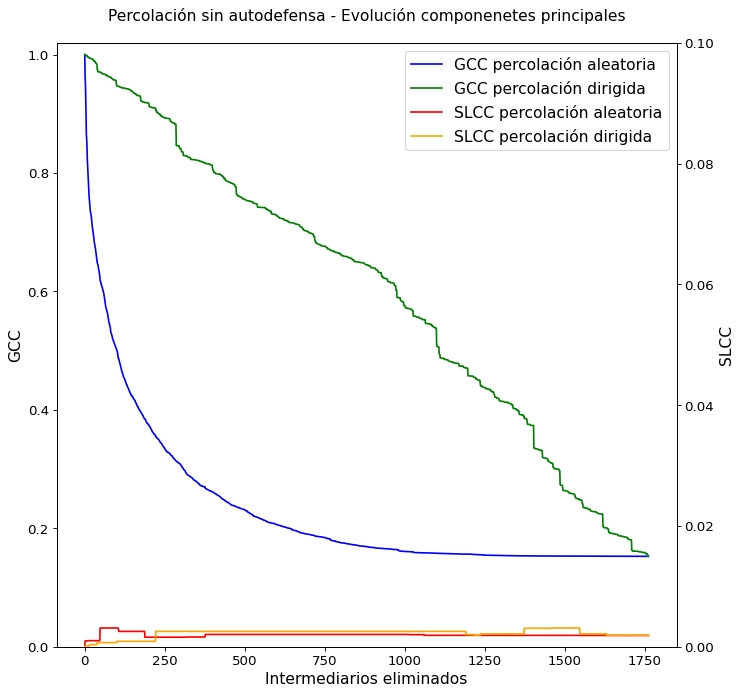

In [38]:
# Plot percolations without autodefense
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación sin autodefensa - Evolución componenetes principales',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

x_val_gcc_random = [x[0] for x in scatter_gcc_random]
y_val_gcc_random = [x[1] for x in scatter_gcc_random]
x_val_slcc_random = [x[0] for x in scatter_slcc_random]
y_val_slcc_random = [x[1] for x in scatter_slcc_random]

ax2 = ax1.twinx()
lns0 = ax1.plot(x_val_gcc_random, y_val_gcc_random, color='blue',label="GCC percolación aleatoria")
lns1 = ax1.plot(x_val_gcc, y_val_gcc, color='green',label="GCC percolación dirigida")
lns2 = ax2.plot(x_val_slcc_random, y_val_slcc_random, color='red',label="SLCC percolación aleatoria")
lns3 =ax2.plot(x_val_slcc, y_val_slcc, color='orange',label="SLCC percolación dirigida")
lns = lns0+lns1+lns2+lns3
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
ax1.tick_params(axis="x", labelsize=12) 
ax1.tick_params(axis="y", labelsize=12)
plt.yticks(fontsize=12)
plt.show()

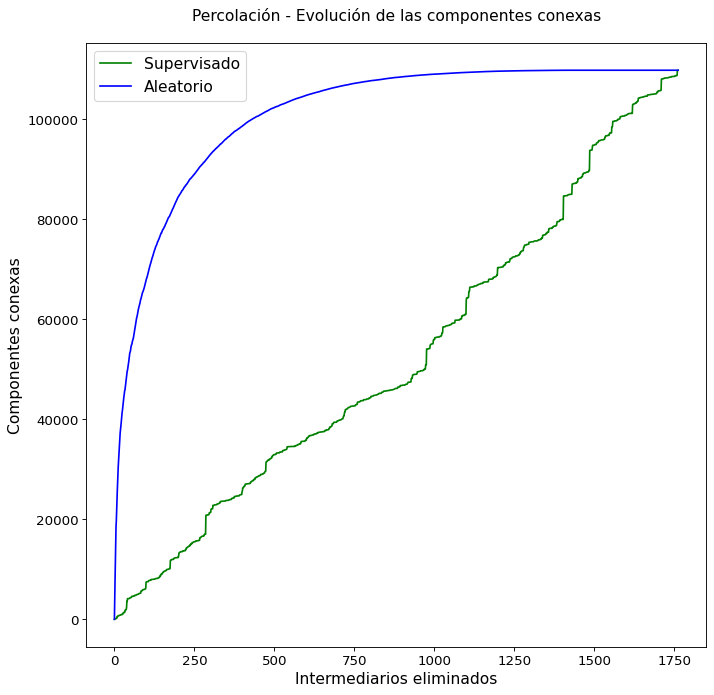

In [41]:
# Plot evolution of connected components 
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación - Evolución de las componentes conexas',fontsize=14,pad=20)
x_val_cc = [x[0] for x in scatter_cc]
y_val_cc = [x[1] for x in scatter_cc]
x_val_cc_random = [x[0] for x in scatter_cc_random]
y_val_cc_random = [x[1] for x in scatter_cc_random]

ax1.plot(x_val_cc, y_val_cc, 'g-',label="Supervisado")
ax1.plot(x_val_cc_random, y_val_cc_random, 'b-',label="Aleatorio")
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylabel('Componentes conexas',fontsize=14)
ax1.legend(loc="upper left",fontsize=14)
#ax1.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

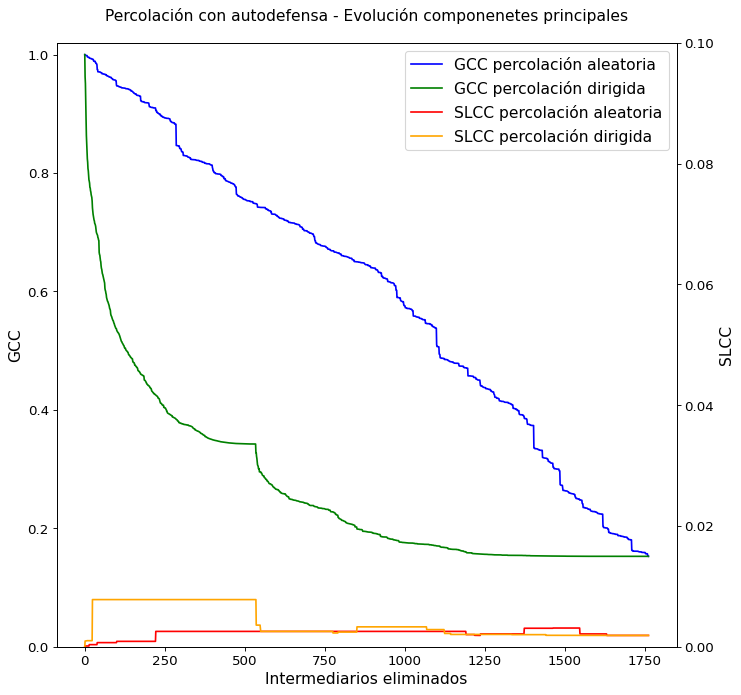

In [46]:
# Percolations with autodefense
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación con autodefensa - Evolución componenetes principales',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc_auto]
y_val_gcc = [x[1] for x in scatter_gcc_auto]
x_val_slcc = [x[0] for x in scatter_slcc_auto]
y_val_slcc = [x[1] for x in scatter_slcc_auto]

x_val_gcc_random = [x[0] for x in scatter_gcc_auto_random]
y_val_gcc_random = [x[1] for x in scatter_gcc_auto_random]
x_val_slcc_random = [x[0] for x in scatter_slcc_auto_random]
y_val_slcc_random = [x[1] for x in scatter_slcc_auto_random]

ax2 = ax1.twinx()
lns0 = ax1.plot(x_val_gcc_random, y_val_gcc_random, color='blue',label="GCC percolación aleatoria")
lns1 = ax1.plot(x_val_gcc, y_val_gcc, color='green',label="GCC percolación dirigida")
lns2 = ax2.plot(x_val_slcc_random, y_val_slcc_random, color='red',label="SLCC percolación aleatoria")
lns3 =ax2.plot(x_val_slcc, y_val_slcc, color='orange',label="SLCC percolación dirigida")
lns = lns0+lns1+lns2+lns3
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
ax1.tick_params(axis="x", labelsize=12) 
ax1.tick_params(axis="y", labelsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
## Supervised percolation with autodefense
total_graph = G.number_of_nodes()
scatter_gcc = [[0,1]] # Proportion GCC at each iteration
scatter_slcc = [[0,0]] # Proportion SLCC at each iteration
scatter_cc = [[0,1]] # Number of components at each iteration
current_length_gcc = total_graph
Percolation_graph = G.copy() # Make a graph copy
i=1
while current_length_gcc/total_graph > 0.05: # Stop critery
    # Intermediary with greatest degree
    max_degree_id = max(dict(Percolation_graph.degree(labels['Intermediary'])), key=dict(Percolation_graph.degree(labels['Intermediary'])).get)
    recompute_edges(Percolation_graph,max_degree_id)# Autodefense
    Percolation_graph.remove_node(max_degree_id)# Intermediary removal
    G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    scatter_cc.append([i,len(G_sorted)]) # Number of connected components
    Gcc = Percolation_graph.subgraph(G_sorted[0]) # Get GCC
    Slcc = Percolation_graph.subgraph(G_sorted[1]) # Get SLCC
    current_length_gcc = len(Gcc)
    current_length_slcc = len(Slcc)
    print('The total number of components in Gcc is: ',current_length_gcc)
    print('The total number of components in Slcc is: ',current_length_slcc)
    print('Proportion gcc',current_length_gcc/total_graph)
    print('Proportion slcc',current_length_slcc/total_graph)
    scatter_gcc.append([i,current_length_gcc/total_graph])
    scatter_slcc.append([i,current_length_slcc/total_graph])
    i=i+1
    print(i)

In [ ]:
# Export to files, due to high time computation.
'''
with open('gcc_max_defensaae.txt', 'w') as f:
    for item in scatter_gcc:
        f.write("%s\n" % item)
with open('slcc_max_daaaefense.txt', 'w') as f:
    for item in scatter_slcc:
        f.write("%s\n" % item)
with open('cc_max_defaaaaense.txt', 'w') as f:
    for item in scatter_cc:
        f.write("%s\n" % item)
'''

In [43]:
# Load from files, due to high time computation.
"""
import ast
scatter_gcc_auto = []
scatter_slcc_auto = []
scatter_cc_auto = []
with open('gcc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_gcc_auto.append(eval(line.strip()))
with open('slcc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_slcc_auto.append(eval(line.strip()))
with open('cc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_cc_auto.append(eval(line.strip()))
""""""

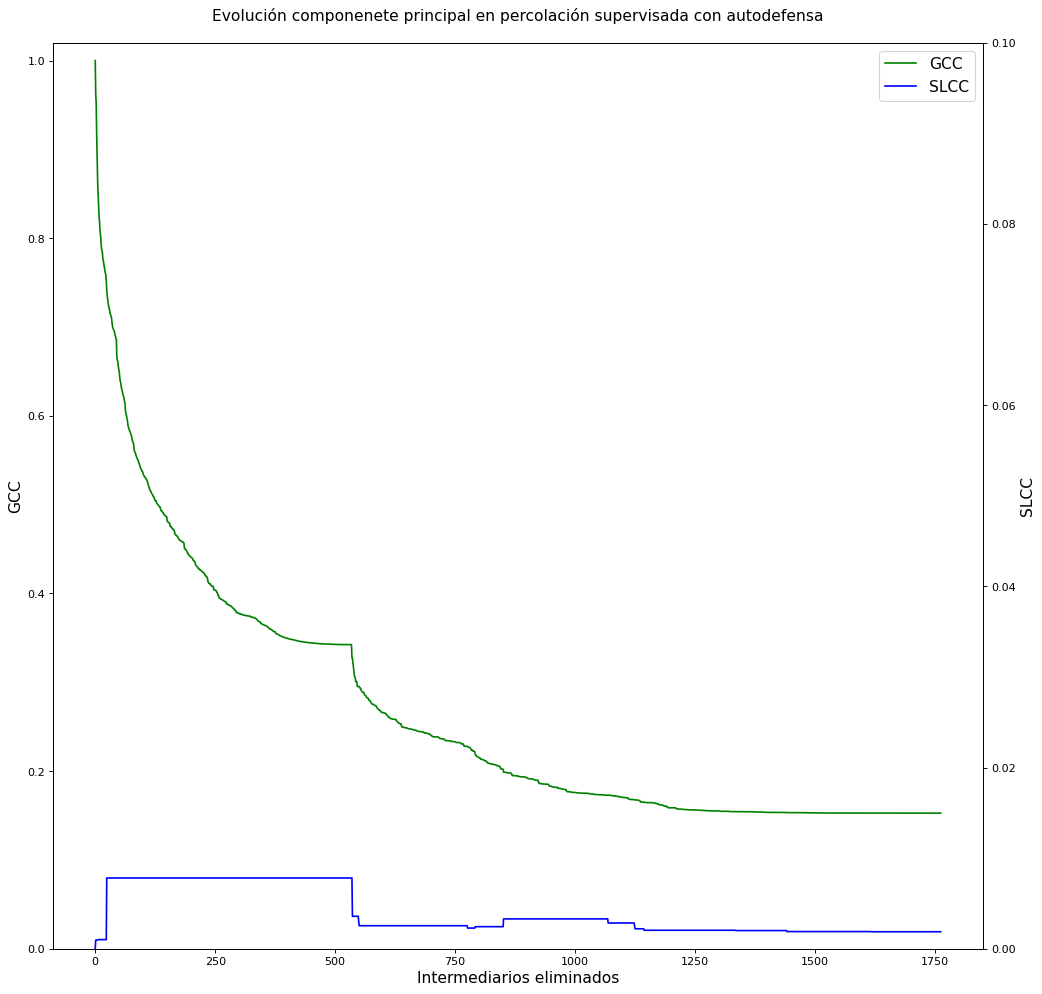

In [52]:
# Supervised percolation with autodefense plot
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación supervisada con autodefensa',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc_auto]
y_val_gcc = [x[1] for x in scatter_gcc_auto]
x_val_slcc = [x[0] for x in scatter_slcc_auto]
y_val_slcc = [x[1] for x in scatter_slcc_auto]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_slcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
ax2.set_ylim([0, 0.1])
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
plt.show()

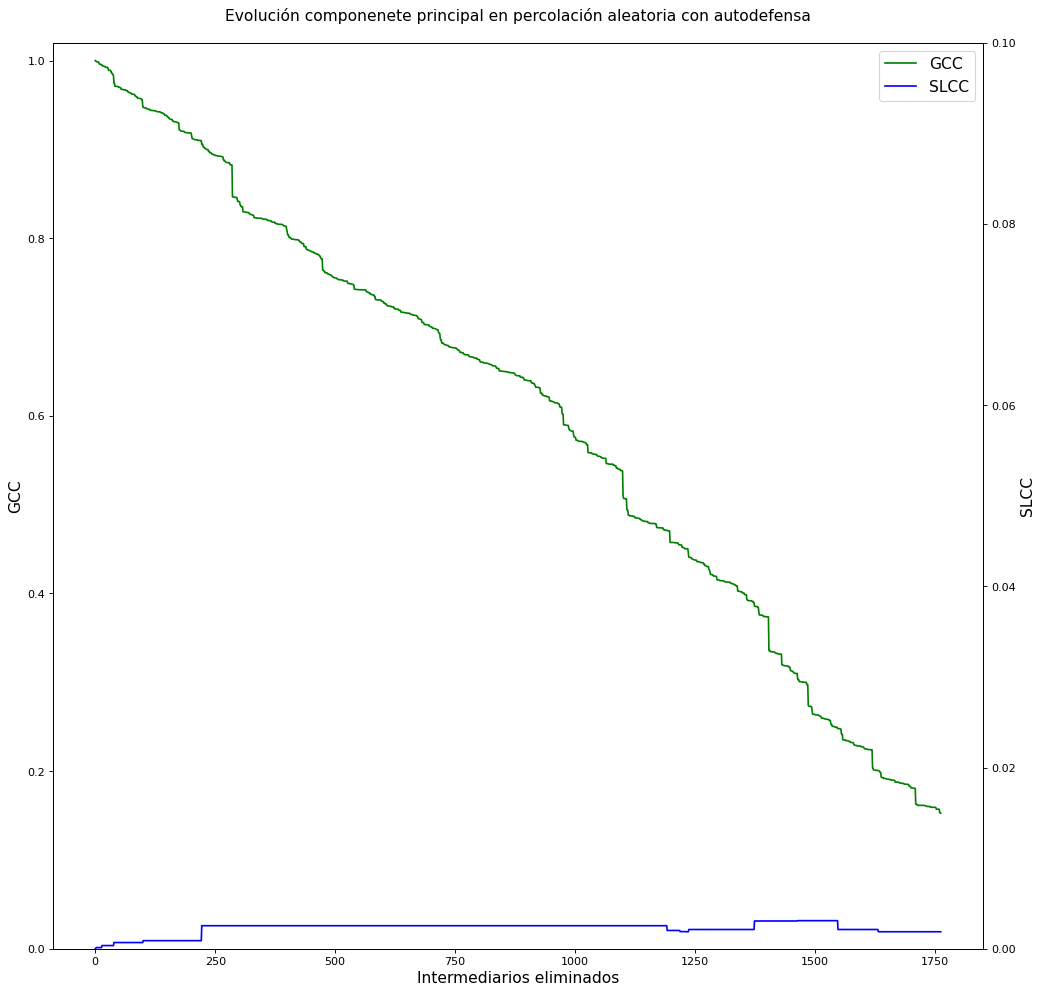

In [53]:
# Supervised percolation with autodefense plot
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación aleatoria con autodefensa',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc_auto_random]
y_val_gcc = [x[1] for x in scatter_gcc_auto_random]
x_val_slcc = [x[0] for x in scatter_slcc_auto_random]
y_val_slcc = [x[1] for x in scatter_slcc_auto_random]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_slcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
plt.show()

In [ ]:
### OLD PLOT
# Percolations with autodefense plot
fig, axs = plt.subplots(2,1,figsize=(20,20),dpi=80)
fig.suptitle('Evolución componentes principal en percolación aleatoria con autodefensa',fontsize=18)
fig.subplots_adjust(top=0.92)

x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

ax2 = axs[0].twinx()
lns1 = axs[0].plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
axs[0].set_xlabel('Intermediarios eliminados',fontsize=14)
axs[0].set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
axs[0].set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs, loc=0,fontsize=14)
axs[0].set_title('Supervisada',fontsize=16,pad=20)

x_val_gcc = [x[0] for x in scatter_random_gcc]
y_val_gcc = [x[1] for x in scatter_random_gcc]
x_val_sgcc = [x[0] for x in scatter_random_slcc]
y_val_sgcc = [x[1] for x in scatter_random_slcc]

ax2 = axs[1].twinx()
lns1 = axs[1].plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_slcc, 'b-',label="SLCC")
lns = lns1+lns2
axs[1].set_xlabel('Intermediarios eliminados',fontsize=14)
axs[1].set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
axs[1].set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs, loc=0,fontsize=14)
axs[1].set_title('Aleatoria',fontsize=16,pad=20)
plt.show()